# Bay Wheels Bike Sharing System Usage Pattern
## by Yash Ahuja

## Investigation Overview

> Bay Wheels is a public bicycle sharing system in the San Francisco Bay Area, California. I'm most interested in exploring the bike trips' duration and rental events occurrance patterns in terms of time of day, day of the week, along with how these relate to the riders' characteristics, i.e. their user type, gender, age, etc. to get a sense of what and how people are using the bike sharing service for. 

## Dataset Overview

> The dataset consists of approx. 180,000+ bike trips that happened in Feb 2019 covering the San Francisco Bay Area. The data can be downloaded from [here](https://s3.amazonaws.com/baywheels-data/index.html). The dataset contains features regarding trip duration, station information and annonymized member information (user type, gender etc). Visualizations are created from wrangled and cleaned data to facilitate exploration analysis and help discover usage pattern and rider characteristics.

In [16]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2021)
%matplotlib inline
# suppress warnings from final output
import warnings
warnings.filterwarnings('ignore')

In [17]:
# load in the wrangled and cleaned dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [18]:
# Preliminary wrangling tasks
# Removing missing values
df = df[(df['start_station_id'].isnull() == False) & (df['start_station_name'].isnull() == False) \
   & (df['member_birth_year'].isnull() == False) & (df['member_gender'].isnull() == False)]
# Dealing with invalid data types
df.start_station_id = df.start_station_id.astype(str)
df.end_station_id = df.end_station_id.astype(str)
df.bike_id = df.bike_id.astype(str)
df.user_type = df.user_type.astype('category')
df.bike_share_for_all_trip = df.bike_share_for_all_trip.astype('category')
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
# Extracting hour, day from start time and age from birth year
df['hour'] = df.start_time.dt.hour.astype(str)
df['dayofweek'] = df.start_time.dt.strftime('%a')
df['member_age'] = 2021 - df['member_birth_year'].astype(int)
# Convert the "day" column from a plain object type into an ordered categorical type
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_type = pd.api.types.CategoricalDtype(ordered = True, categories = days)
df.dayofweek = df.dayofweek.astype(day_type)
# Convert the "hour" column from a plain object type into an ordered categorical type
hours = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
hour_type = pd.api.types.CategoricalDtype(ordered = True, categories = hours)
df.hour = df.hour.astype(hour_type)
# Tidying the dataset
df.drop(['start_time', 'member_birth_year'], axis=1, inplace=True)
# converting duration into minutes for easy interpretation
df['duration_min'] = df['duration_sec']/60

## Distribution of Trip Duration

Trip Durations in the dataset take on a very large range of values, from about approx. 1 minute at the lowest, to about approx. 1409 minutes at the highest and average trip duration is approx. 9 minutes. Plotted on a logarithmic scale and setting 100 minutes as the upper bound, the distribution of trip duration takes on a bell curve shape approximating to a normal distribution. It is evident that approx. 95% of the trips have duration around 25 minutes implicating that on average, the trips are of short duration.

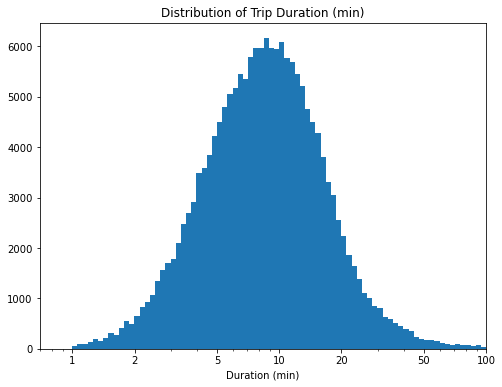

In [19]:
log_binsize=0.025
bin_edges=10 ** np.arange(0, np.log10(df.duration_min.max())+log_binsize, log_binsize)
plt.figure(figsize=[8,6])
plt.hist(data=df, x='duration_min', bins=bin_edges)
plt.xscale('log')
plt.xticks([1,2,5,10,20,50,100,200,500,1000,2000],[1,2,5,10,20,50,100,200,500,'1k','2k'])
plt.xlabel('Duration (min)')
plt.xlim([0,100])
plt.title('Distribution of Trip Duration (min)')
plt.show()

## Distribution of Member Age

Average member age is 34 years. The distribution of age was also positively skewed with some outliers at the end but instead of log scaling at first, we tried to limit the range to check if we can find any pattern. Based on the histogram plot, we chose 70 years as the upper bound to analyse the pattern by focusing on the most common trips. After setting 70 years as the upper bound, the trend was clearly visible, with age still following a positively skewed distribution having more than two thirds of the trips have customers or subscribers having age 25-40 years implicating that majority of the users are middle aged adults.

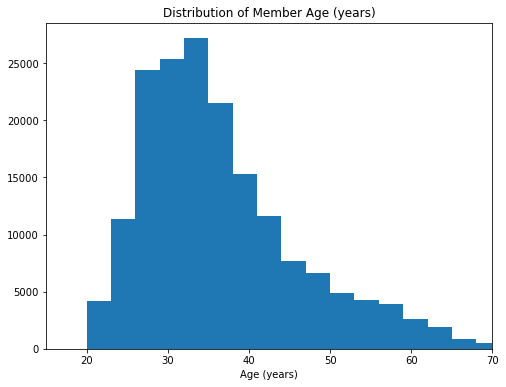

In [20]:
binsize=3
bin_edges=np.arange(20, df.member_age.max()+binsize, binsize)
plt.figure(figsize=[8,6])
plt.hist(data=df, x='member_age', bins=bin_edges)
plt.xlabel('Age (years)')
plt.xlim([15,70])
plt.title('Distribution of Member Age (years)')
plt.show()

In [21]:
# Removing age and duration outliers based on histogram plots 
outliers = ((df.duration_min>100) | (df.member_age>70))
df = df[-outliers]

## Trip Duration & Age of riders across different days of the week

- On average, bike rides on weekends (Sat-Sun) have longer durations as compared to bike rides on other weekdays (Mon-Fri).
- On average, bikers on weekdays (Mon-Fri) are older than bikers on weekends (Sat-Sun).

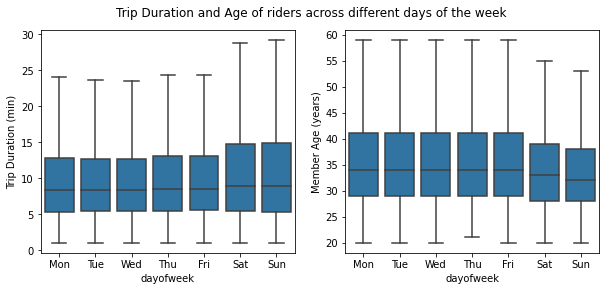

In [22]:
fig, ax = plt.subplots(1,2, figsize=[10,4])
default_color = sns.color_palette()[0]
#setting showfliers = False to remove extreme values
sns.boxplot(data=df, x='dayofweek', y='duration_min', showfliers=False, color=default_color, ax=ax[0])
ax[0].set_ylabel('Trip Duration (min)')
sns.boxplot(data=df, x='dayofweek', y='member_age', showfliers=False, color=default_color, ax=ax[1])
ax[1].set_ylabel('Member Age (years)')
plt.suptitle('Trip Duration and Age of riders across different days of the week')
#adjusting figure main title
fig.subplots_adjust(top =0.90)
plt.show()

## Trip Duration & Age of riders across different user & gender types

- On average, users who are 'Customer' have longer bike trip durations as compared to users who are 'Subscriber'.
- On average, female bikers have longer bike trip durations as compared to male bikers.
- The average age of male bikers is higher than that of female bikers.
- The average age of 'Subscriber' and 'Customer' type bikers is approximately same. However, Subscriber user type has more older people compared to customer user type and the same goes for male users over female users.

In [23]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

df['log_duration'] = df['duration_min'].apply(log_trans)

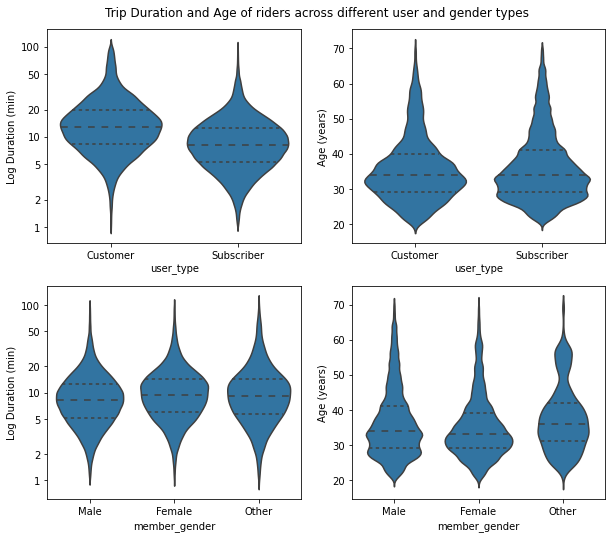

In [24]:
fig , ax = plt.subplots(2,2, figsize=[10,8])
cat_vars = ['user_type', 'member_gender']
for i in range(len(cat_vars)):
    var = cat_vars[i]
    sns.violinplot(data=df, x=var, y='log_duration', color=default_color, inner='quartile', ax=ax[i,0])
    ax[i,0].set_yticks(log_trans(np.array([1,2,5,10,20,50,100])))
    ax[i,0].set_yticklabels([1,2,5,10,20,50,100])
    ax[i,0].set_ylabel('Log Duration (min)')
    sns.violinplot(data=df, x=var, y='member_age', color=default_color, inner='quartile', ax=ax[i,1])
    ax[i,1].set_ylabel('Age (years)')
plt.suptitle('Trip Duration and Age of riders across different user and gender types')
#adjusting figure main title
fig.subplots_adjust(top =0.94)
plt.show()

## Daily and Weekly Bike Trip Trends of different user types

- Thursday, 8 AM and 5 PM has the highest bike trips across 7 days and 24 hours.

- Overall, weekdays have higher number of trips than weekends except two time frames:

    1. 10 AM - 3 PM (the usual office hours) in which both have approx. same number of trips.
    2. 12 midnight to 2 AM in which weekends have more trips than weekdays.


- Overall, Subscribers have higher number of trips than customers across all times of the day. Moreover, 8 AM and 5 PM has the most 'Subscriber' bikers compared to other hours. Also, 5 PM has the most 'Customer' bikers compared to other times of the day.

- Overall, Subscribers have higher number of trips than customers across all days of the week. Moreover, Thursday has the most 'Subscriber' and 'Customer' bikers compared to other days.

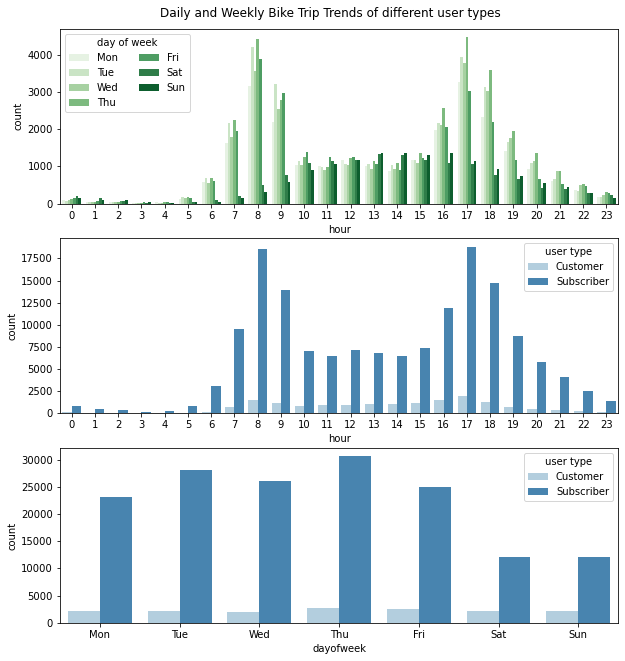

In [25]:
fig, ax = plt.subplots(nrows=3, figsize=[10,10])

sns.countplot(data=df, x='hour', hue='dayofweek', palette='Greens', ax=ax[0])
ax[0].legend(title='day of week', ncol=2)
sns.countplot(data=df, x='hour', hue='user_type', palette='Blues', ax=ax[1])
ax[1].legend(title='user type')
sns.countplot(data=df, x='dayofweek', hue='user_type', palette='Blues', ax=ax[2])
ax[2].legend(title='user type')
plt.suptitle('Daily and Weekly Bike Trip Trends of different user types')
#adjusting figure main title
fig.subplots_adjust(top =0.95)
plt.show()

## Daily and Weekly Bike Trip Trends of different gender types

- Overall, male bikers have higher number of trips as compared to female and other gender type across all the times of the day (hour) and days of the week.
- Most of the Subscriber bikers are male. Most of the Customer bikers are also male.
- 8 AM and 5 PM has the highest male and female bikers across 24 hours
- Thursday has the most male bikers compared to other days. It also has the most female bikers compared to other days.


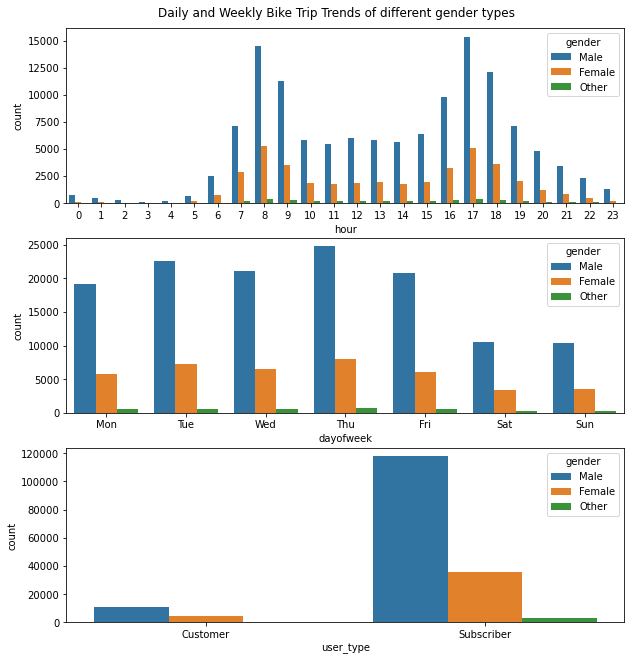

In [26]:
fig, ax = plt.subplots(nrows=3, figsize=[10,10])

sns.countplot(data=df, x='hour', hue='member_gender', palette='tab10', ax=ax[0])
ax[0].legend(title='gender')
sns.countplot(data=df, x='dayofweek', hue='member_gender', palette='tab10', ax=ax[1])
ax[1].legend(title='gender')
sns.countplot(data=df, x='user_type', hue='member_gender', palette='tab10', ax=ax[2])
ax[2].legend(title='gender')
plt.suptitle('Daily and Weekly Bike Trip Trends of different gender types')
#adjusting figure main title
fig.subplots_adjust(top =0.95)
plt.show()

## Daily and Weekly Average Bike Trip Duration of different user and gender types

- Customers have higher average bike trip duration than subscribers across all the times of the day (hour) and days of the week with customers having higher average bike trip duration on weekends (Sat-Sun) as compared to weekdays (Mon-Fri) and the same could not be said for subsribers as their difference between weekdays and weekends in terms of average bike trip durations is not significant.
- Female bikers have higher average bike trip duration than male bikers across all the days of the week with female bikers having higher average bike trip duration on weekends (Sat-Sun) as compared to weekdays (Mon-Fri) and same goes for male bikers.

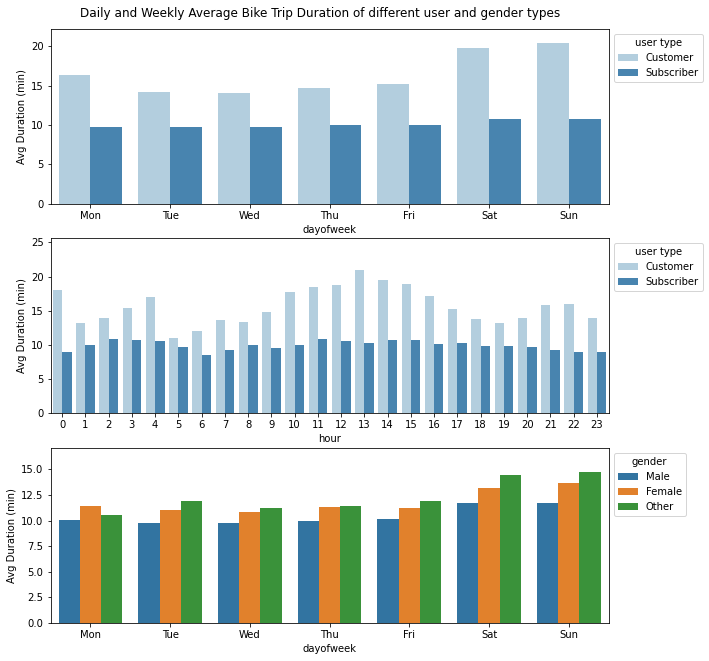

In [27]:
 fig, ax = plt.subplots(nrows=3, figsize=[10,10])

sns.barplot(data=df, x='dayofweek', y='duration_min', hue='user_type', palette='Blues', errwidth=0, ax=ax[0])
ax[0].set_ylabel('Avg Duration (min)')
ax[0].legend(loc=2, title='user type', bbox_to_anchor=(1,1))
sns.barplot(data=df, x='hour', y='duration_min', hue='user_type', palette='Blues', errwidth=0, ax=ax[1])
ax[1].set_ylabel('Avg Duration (min)')
ax[1].legend(loc=2, title='user type', bbox_to_anchor=(1,1))
sns.barplot(data=df, x='dayofweek', y='duration_min', hue='member_gender', palette='tab10', errwidth=0, ax=ax[2])
ax[2].set_ylabel('Avg Duration (min)')
ax[2].legend(loc=2, title='gender', bbox_to_anchor=(1,1))
plt.suptitle('Daily and Weekly Average Bike Trip Duration of different user and gender types')
#adjusting figure main title
fig.subplots_adjust(top =0.95)
plt.show()

## Combining all the usage patterns together for Customers and Subscribers

- A very different usage pattern is observed between the two type of bike riders. Subscribers use the bike sharing system heavily on work days i.e. Monday through Friday whereas customers ride a lot on weekends i.e. Saturday and Sunday, especially in the afternoon. Many trips are concentrated around 8-9 AM and 4-6 PM on work days for subscribers who probably use the system for work commute, yet customers tend to use more in the late afternoon around 5 PM on weekdays (Monday to Friday). Other than usage purpose and habit, traffic situation around these rush hours in the area may also have an influence in this trend.  

- The efficient/short period of usage for subscribers, involving more older people as compared to customer bikers, corresponds to their high concentration on rush hours Monday through Friday, indicating that they use the system heavily on weekdays, compared to customer bikers, primarily for work commute. Whereas, customer bikers who have more younger people as compared to the subscribers have more relaxing and flexible usage pattern. It is supported by the fact that they're taking advantage of the bike sharing system quite differently from the subscribers as they use the system heavily on weekends (especially in the afternoon) compared to subscribers for city tour or leisure purpose probably which will be investigated further.

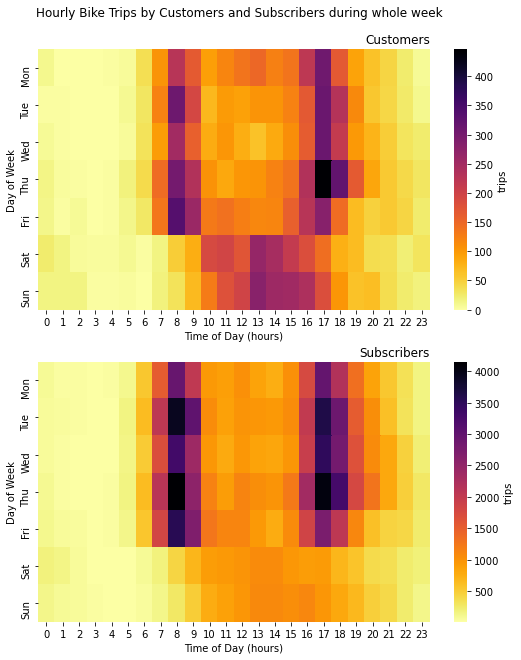

In [28]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])

fig.suptitle('Hourly Bike Trips by Customers and Subscribers during whole week')

customers = df.query('user_type == "Customer"')
ct_counts = customers.groupby(['dayofweek', 'hour']).size()
ct_counts = ct_counts.reset_index(name='trips')
ct_counts = ct_counts.pivot(index='dayofweek', columns=['hour'], values='trips')
sns.heatmap(data=ct_counts, fmt='.0f',cmap='inferno_r', cbar_kws={'label':'trips'}, ax=ax[0])
ax[0].set_title('Customers', loc='right')
ax[0].set_xlabel('Time of Day (hours)')
ax[0].set_ylabel('Day of Week')


subscribers = df.query('user_type == "Subscriber"')
sb_counts = subscribers.groupby(['dayofweek', 'hour']).size()
sb_counts = sb_counts.reset_index(name='trips')
sb_counts = sb_counts.pivot(index='dayofweek', columns=['hour'], values='trips')
sns.heatmap(data=sb_counts, fmt='.0f', cmap='inferno_r', cbar_kws={'label':'trips'}, ax=ax[1])
ax[1].set_title('Subscribers', loc='right')
ax[1].set_xlabel('Time of Day (hours)')
ax[1].set_ylabel('Day of Week')
#adjusting figure main title
fig.subplots_adjust(top =0.92, left=0.22)
plt.show()

## Digging further...

### Analyzing the Average Bike Trip duration of Customers and Subscribers for different age groups:
***Middle aged adults (20-40 years) and Adults (more than 40)***

The insight observed earlier regarding usage pattern of customers and subscribers is further supported by the fact that when we used the findings from the univariate exploration that most of the bikers were in the age group 25-40 years and divided the users into two separate age groups middle aged adults (20-40) and adults (more than 40), it was found that Customer bikers bike longer than Subscriber bikers for both middle aged adults and adults. Additionally, 'Customer' bikers bike longer on weekends as compared to weekdays for both middle aged adults and adults implicating that they use the system heavily for leisure purposes whereas the difference between weekdays and weekends in terms of biking duration for both middle aged adults and adults is insignificant in case of Subscriber bikers as they use the system primarily for work commute.

In [29]:
# divide the age into two categories i.e. middle aged adults (20-40) and adults (>40)
middle_adults = df[df['member_age'] <= 40]
adults = df[df['member_age'] > 40 ]

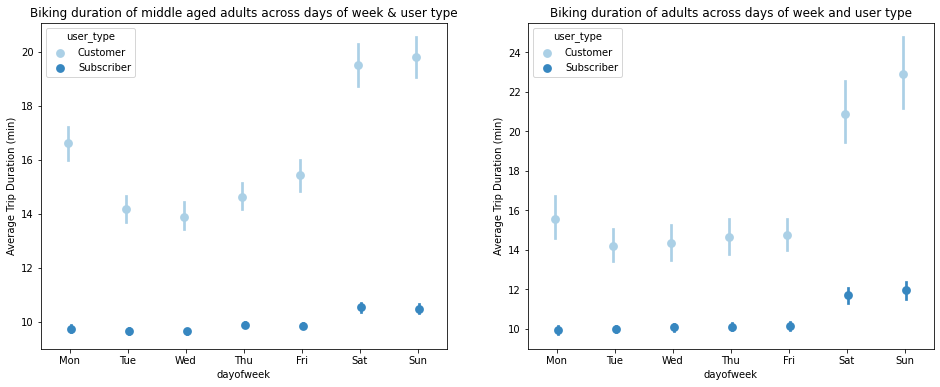

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=[16,6])

sns.pointplot(data=middle_adults, x='dayofweek', y='duration_min', hue='user_type', linestyles="", palette='Blues', dodge=True, 
              ax=ax[0])
ax[0].set_title('Biking duration of middle aged adults across days of week & user type')
ax[0].set_ylabel('Average Trip Duration (min)')

sns.pointplot(data=adults, x='dayofweek', y='duration_min', hue='user_type', linestyles="", palette='Blues', dodge=True, \
                  ax=ax[1])
ax[1].set_title('Biking duration of adults across days of week and user type')
ax[1].set_ylabel('Average Trip Duration (min)')
plt.show()